In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *

# Load pre-processed Perturbseq experiment from hdf5

Populations are constructed in notebook *20180822 GI generate populations*

In [2]:
pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/final_single_cell_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 30.7999007702s.
Done.


In [3]:
pop.info()

Matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: int32(24665)
memory usage: 8.6 GB

Normalized matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: float64(24665)
memory usage: 17.2 GB


In [4]:
control_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/control_pop.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 2.49951505661s.
Done.


In [5]:
mean_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/mean_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.185831069946s.
Done.


# Load emap information

In [6]:
# these have different names in the emap and in GChr38
name_replacer = {'C3orf72': 'FOXL2NB',
                 'C19orf26': 'CBARP',
                 'KIAA1804': 'RP5-862P8.2',
                 'RHOXF2': 'RHOXF2B',
                }

inverse_name_replacer = {v: k for k, v in name_replacer.iteritems()}

In [7]:
emap = pd.read_csv('./final_emaps/processed_emap.csv', index_col=[0])
phen_matrix = pd.read_csv('./final_emaps/processed_fitnesses.csv', index_col=[0])
single_phen = pd.read_csv('./final_emaps/single_fitnesses.csv', index_col=[0])

In [8]:
# this is average fitness across two guides in primary emap, not single guide used for perturbseq
single_fitnesses = single_phen['average_fitness']

# fitness mapper, maps names to raw fitness values
fitness_mapper = dict()
for perturbation in pop.cells['guide_target'].unique():
    first, second = perturbation.split('_')
    try:
        if 'NegCtrl' in second:
            fitness_mapper[perturbation] = single_fitnesses.loc[first]
        elif 'NegCtrl' in first:
            fitness_mapper[perturbation] = single_fitnesses.loc[second]
        else:
            fitness_mapper[perturbation] = phen_matrix.loc[first, second]
    except KeyError:
        fitness_mapper[perturbation] = np.nan

In [9]:
single_genes = np.intersect1d(reduce(np.union1d, mean_pop.cells.query('num_targets == 1')['guide_target'].map(lambda x: x.split('_'))),
               emap.columns.map(lambda x: name_replacer.get(x, x)))
# we know these don't work...
single_genes = np.setdiff1d(single_genes, ['BAK1', 'BCL2L11'])

# maps gene name to single (SLC38A2 is the lone exception where we don't have it in position 1)
single_gene_perturbations = dict()

for gene in single_genes:
    if gene + '_NegCtrl0' in mean_pop.cells.index:
        single_gene_perturbations[gene] = gene + '_NegCtrl0'
    elif 'NegCtrl0_' + gene in mean_pop.cells.index:
        single_gene_perturbations[gene] = 'NegCtrl0_' + gene
        
double_perturbations = mean_pop.cells.query('num_targets == 2').index
perturbations = single_gene_perturbations.values()

for p in double_perturbations:
    gene1, gene2 = p.split('_')
    if gene1 in single_genes and gene2 in single_gene_perturbations.keys():
        perturbations.append(p)
        
fitnesses = mean_pop.cells.loc[perturbations, 'fitness']

# add a negative control
perturbations = np.union1d(perturbations, 'NegCtrl0_NegCtrl0')
single_gene_perturbations['negative'] = 'NegCtrl0_NegCtrl0'
fitnesses['NegCtrl0_NegCtrl0'] = 0.0

mapper = {v: k for k, v in single_gene_perturbations.iteritems()}

# Regenerate clustering

We will compare the the clustering that was used to make Figure 2 from the notebook *GI_optimal_umap*

In [10]:
import hdbscan

clusterer = hdbscan.HDBSCAN(metric='correlation',
                            min_cluster_size=4,
                            min_samples=1,
                            cluster_selection_method='eom',
                            alpha=1.)

In [11]:
data = mean_pop.where(genes='mean > 0.25',
                      normalized=True,
                      gene_names=True
                     )
data = data/data.std()

In [12]:
clusterer.fit(data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='correlation', min_cluster_size=4, min_samples=1, p=None,
    prediction_data=False)

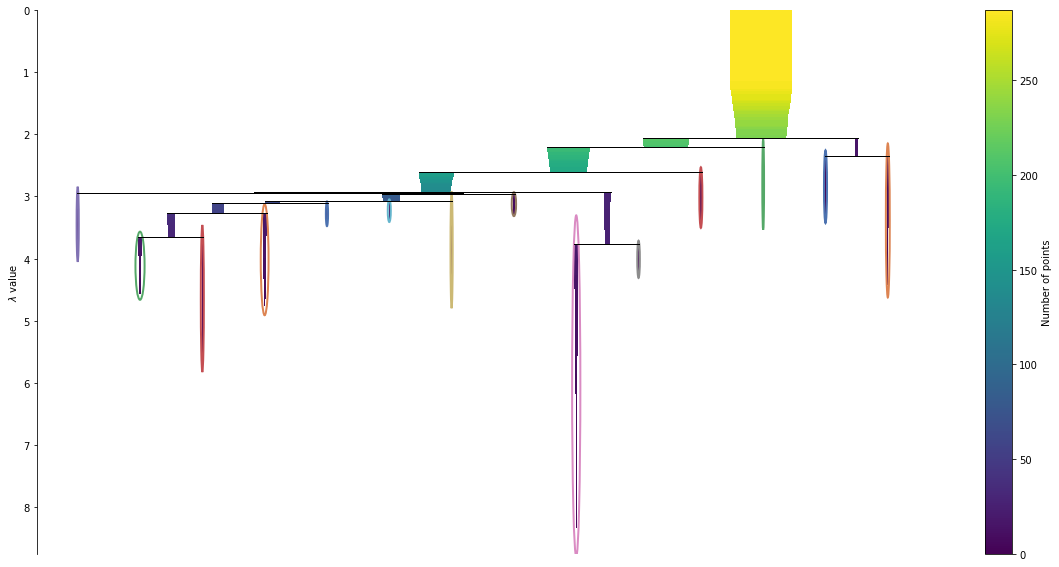

In [13]:
plt.figure(figsize=[20,10])
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 40))

In [14]:
from scipy.cluster.hierarchy import leaves_list, optimal_leaf_ordering
from scipy.spatial.distance import pdist, squareform
from sklearn.utils import shuffle
from matplotlib.colors import to_hex

The set of distances `D_corr` below will be what we compare to when downsampling

In [15]:
D_corr = pdist(data, 'correlation')
Z_corr = clusterer.single_linkage_tree_.to_numpy()
Z_corr = optimal_leaf_ordering(Z_corr, D_corr)
labels = pd.Series(clusterer.labels_, index=data.index).sort_values()
clusters_in_order = labels.loc[data.index.values[leaves_list(Z_corr)]]

cluster_colors = map(to_hex, sns.color_palette('hls', labels.max()+2))
cluster_colors = shuffle(cluster_colors)
cluster_color_mapper = dict(zip(sorted(labels.unique()), cluster_colors))
cluster_color_mapper[-1] = '#cccccc'
cluster_colors = clusters_in_order.map(lambda x: cluster_color_mapper[x])

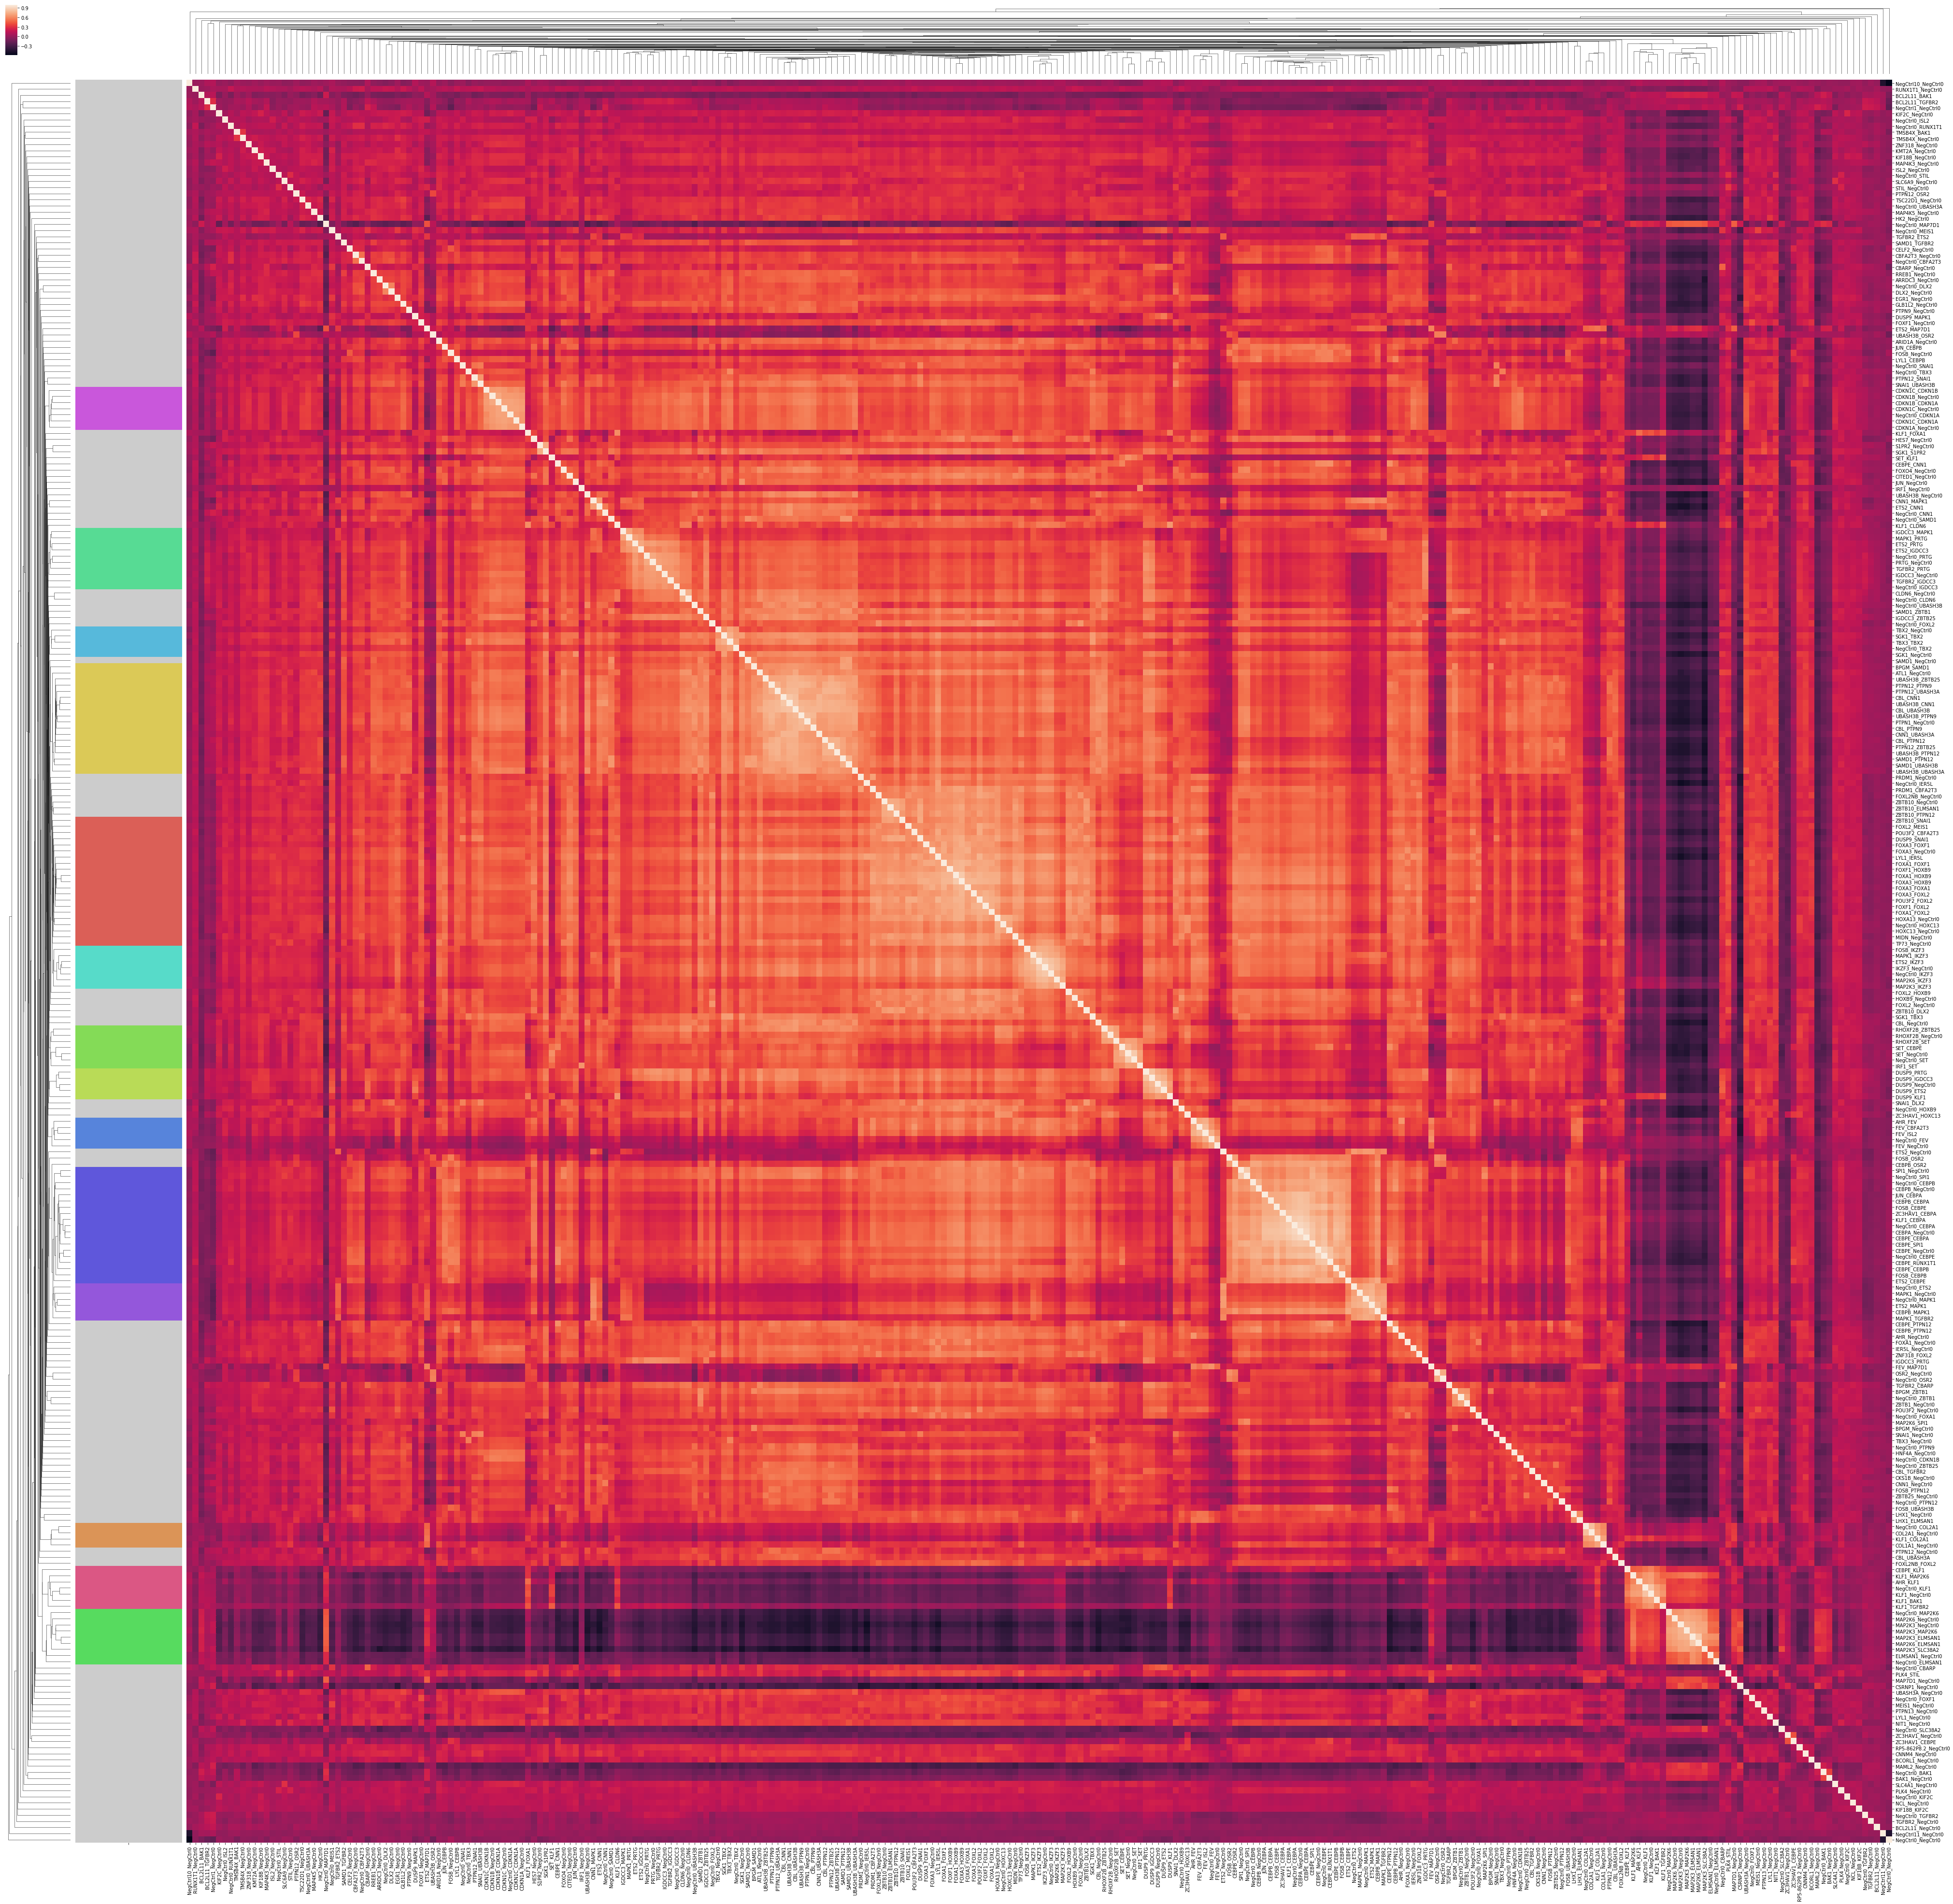

In [16]:
sns.clustermap(data.T.corr(), 
               row_linkage=Z_corr, col_linkage=Z_corr,
               robust=False, figsize=[70,70], row_colors=cluster_colors)

# Downsampling population

In [17]:
# this is used in random sampling. It randomly samples without replacement but will return
# at most all cells that exist. (E.g. if we subsample to ask for 100 cells of each condition
# and some condition only has 75, only those 75 cells will be returned. Any condition with
# 100 or more cells will have 100 returned randomly, without replacement.)

def max_sample_index(df, n, seed=None):
    if df.shape[0] < n:
        n_samples = df.shape[0]
    else:
        n_samples = n
    np.random.seed(seed)
    return np.random.choice(df.index, size=n_samples, replace=False)

In [18]:
import cPickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [19]:
import itertools as it

In [20]:
targets = [10, 20, 30, 50, 100]
iters = np.arange(0, 50)

In [21]:
import gc, os

This performs the actual downsampling. Results are stored in a subdirectory `./downsampled_pop` as they are created.

In [22]:
def downsample_pop(n, label, seed):
    filename = './downsampled_pops/pop_samples_{0}_iter_{1}.hdf'.format(n, label)
    if not os.path.isfile(filename): 
        random_cells = pop.groupby_map('guide_target',
                           {'random_sample': lambda x: max_sample_index(x, n, seed=seed)},
                          show_progress=True)

        random_indexes = reduce(np.union1d, random_cells.values())
        subpop = pop.subpopulation(cells=random_indexes, normalized_matrix='inherit')
        down_mean_pop = subpop.average('guide_target', show_progress=True)

        save_obj(random_indexes, './downsampled_pops/index_samples_{0}_iter_{1}'.format(n, label))
        down_mean_pop.to_hdf(filename, store_normalized_matrix=True)
        del subpop
        del down_mean_pop
        gc.collect()
    else:
        print('Skipping {0}...'.format(filename))

Generate a whole bunch of randomly subsampled populations

In [23]:
from joblib import Parallel, delayed

seeds = np.random.randint(0, 2^24, size=len(targets)*len(iters))
out = Parallel(n_jobs=8, verbose=10, batch_size=1)(delayed(downsample_pop)(target, label, seed) 
                                     for (target, label), seed in it.izip(it.product(targets, iters), seeds))

Skipping ./downsampled_pops/pop_samples_10_iter_0.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_1.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_2.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_3.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_4.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_5.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_6.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_7.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_8.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_9.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_10.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_11.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_12.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_13.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_14.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_15.hdf...
Skipping ./downsampled_pops/pop_samples_10_iter_16.hdf...
Skipping ./downsampled_p

Skipping ./downsampled_pops/pop_samples_30_iter_42.hdf...
Skipping ./downsampled_pops/pop_samples_30_iter_43.hdf...
Skipping ./downsampled_pops/pop_samples_30_iter_44.hdf...
Skipping ./downsampled_pops/pop_samples_30_iter_45.hdf...
Skipping ./downsampled_pops/pop_samples_30_iter_46.hdf...
Skipping ./downsampled_pops/pop_samples_30_iter_47.hdf...
Skipping ./downsampled_pops/pop_samples_30_iter_48.hdf...
Skipping ./downsampled_pops/pop_samples_30_iter_49.hdf...
Skipping ./downsampled_pops/pop_samples_50_iter_0.hdf...
Skipping ./downsampled_pops/pop_samples_50_iter_1.hdf...
Skipping ./downsampled_pops/pop_samples_50_iter_2.hdf...
Skipping ./downsampled_pops/pop_samples_50_iter_3.hdf...
Skipping ./downsampled_pops/pop_samples_50_iter_4.hdf...
Skipping ./downsampled_pops/pop_samples_50_iter_5.hdf...
Skipping ./downsampled_pops/pop_samples_50_iter_6.hdf...
Skipping ./downsampled_pops/pop_samples_50_iter_7.hdf...
Skipping ./downsampled_pops/pop_samples_50_iter_8.hdf...
Skipping ./downsampled_

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 205 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Do

Compute all pairwise distances as was done for the clustering in Fig. 2 using all cells.

In [24]:
import glob

results = dict()

for name in glob.glob('./downsampled_pops/*.hdf'):
    temp = name.split('_')
    n_samples = temp[3]
    iteration = temp[5].split('.')[0]
    
    down_mean_pop = CellPopulation.from_hdf(name)
    
    # normalize data as in the original clustering
    down_data = down_mean_pop.where(genes=data.columns,
                      normalized=True,
                      gene_names=True
                     )
    down_data = down_data/down_data.std()
    down_D_corr = pdist(down_data, 'correlation')
    
    corr_dist = np.corrcoef(down_D_corr, D_corr)[0, 1]
    
    results[name] = {'samples': n_samples,
                   'iter': iteration,
                   'corr': corr_dist}

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.204221010208s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.202372789383s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.195760965347s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.196819782257s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.245846033096s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.196123838425s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.18520116806s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.21152305603s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.201719999313s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.200780153275s.
Done.
Loading matrix...
Load

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.180700063705s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.185601949692s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.186920881271s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.183692932129s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.18409705162s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.187622070312s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.188596963882s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.253019094467s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.187638998032s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.188946008682s.
Done.
Loading matrix...
Loa

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.183538913727s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.18003487587s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.180124998093s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.181167840958s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.180098056793s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.179321050644s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.184043884277s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.181854009628s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.184478998184s.
Done.
Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.185976028442s.
Done.
Loading matrix...
Loa

In [25]:
results = pd.DataFrame(results).T
results['corr'] = results['corr'].astype(float)
results['samples'] = results['samples'].astype(float)

In [26]:
def figure_styles():
    sns.set(font_scale=1.)

    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 18

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    sns.set_style('white')
    
figure_styles()

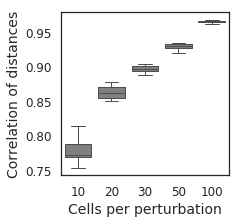

In [27]:
plt.figure(figsize=[3, 3])
sns.boxplot(x='samples', y='corr', data=results, order=targets, color='gray', linewidth=1)
plt.xlabel('Cells per perturbation')
plt.ylabel('Correlation of distances')
plt.savefig('./figures/downsampling_distances.pdf', bbox_inches='tight')